# CNN

Here I've coded an artificial neural network with an arbitrary number of layers. The ANN is encoded in a class, and is fed a dictionary of your choices for activation functions and loss functions, as well as a list of the neurons in each layer, for example a two layer network with 100 and 50, respectively, is fed as [100,50].

Then, the easiest way to search for effective parameters sets is to use RunOne or RunTwo. RunOne will train a one layer NN across the list of options you feed it, then test its accuracy. For example, [10,20,30] will train with 10 neurons, 20 neurons, 30 neurons, and spit out the accuracy for each. Similarly, RunTwo trains in a list of two lists, the first for the number of neurons in the first layer and the second for the second layer. It will train across all combinations and sit out a matrix of accuracies.

Then, once you've identified a good parameter set, use the solitary Train function grouped with RunOne and RunTwo in order to train one a specific parameter set. 

## Load Data Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

def read_dataset(feature_file, label_file):
    ''' Read data set in *.csv to data frame in Pandas'''
    df_X = pd.read_csv(feature_file)
    df_y = pd.read_csv(label_file)
    X = df_X.values # convert values in dataframe to numpy array (features)
    y = df_y.values # convert values in dataframe to numpy array (label)
    return X, y


def normalize_features(X_train, X_test):
    from sklearn.preprocessing import StandardScaler #import libaray
    scaler = StandardScaler() # call an object function
    scaler.fit(X_train) # calculate mean, std in X_train
    X_train_norm = scaler.transform(X_train) # apply normalization on X_train
    X_test_norm = scaler.transform(X_test) # we use the same normalization on X_test
    return X_train_norm, X_test_norm


def one_hot_encoder(y_train, y_test):
    ''' convert label to a vector under one-hot-code fashion '''
    from sklearn import preprocessing
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    y_train_ohe = lb.transform(y_train)
    y_test_ohe = lb.transform(y_test)
    return y_train_ohe, y_test_ohe

## Load the data

In [2]:
# main
X_train_digits, y_train_digits = read_dataset('Digits_X_train.csv', 'Digits_y_train.csv')
X_test_digits, y_test_digits = read_dataset('Digits_X_test.csv', 'Digits_y_test.csv')
X_train_norm_digits, X_test_norm_digits = normalize_features(X_train_digits, X_test_digits)
y_train_ohe_digits, y_test_ohe_digits = one_hot_encoder(y_train_digits, y_test_digits)

# EVERYTHING BELOW IS TESTING! DIVE IN; THE WATER'S FINE

In [289]:
class CFilter:
    def __init__(self,info):
        self.tag = "convolution"
        self.dimensions = info.dimensions
        self.num_filt = info.dimensions[0]
        self.num_ch = info.dimensions[1]
        self.f_i = info.dimensions[2]
        self.f_j = info.dimensions[3]
        self.weight = self.FInitializeFilter()
        self.bias = self.FInitializeBias()
        self.stride_i = info.stride_i
        self.stride_j = info.stride_j
        self.activation = info.activation        
    def FInitializeFilter(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(self.dimensions))),size=self.dimensions)
    def FInitializeBias(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(self.num_filt))),size=(1,self.num_filt))
    
    def FFeedForward(self,images):
        (num_imag, num_ch, imag_i, imag_j) = images.shape

        if(self.num_ch != num_ch):
            print("Big mistake! The number of channels in the filter does not match the number of channels in the images!")

        out_i = int(np.ceil((imag_i - self.f_i)/self.stride_i) + 1)
        out_j = int(np.ceil((imag_j - self.f_j)/self.stride_j) + 1)
        z = np.zeros((num_imag, self.num_filt, out_i, out_j))
        i=0
        for image in images:
            for curr_f in range(self.num_filt):
                curr_y = curr_y_end = out_y = 0
                f_y_end = self.f_j
                while(out_y < out_j):
                    curr_x = curr_x_end = out_x = 0
                    curr_y_end = curr_y + self.f_j
                    if(curr_y_end > imag_j):
                        curr_y_end = imag_j
                        f_y_end = curr_y_end - curr_y
                    f_x_end = self.f_i
                    while(out_x < out_i):
                        curr_x_end = curr_x + self.f_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                            f_x_end = curr_x_end - curr_x
                        z[i,curr_f,out_x,out_y] = np.sum(image[:,curr_x:curr_x_end,curr_y:curr_y_end]*self.weight[curr_f,:,0:f_x_end,0:f_y_end]) + self.bias[0][curr_f]
                        curr_x += self.stride_i
                        out_x += 1
                    curr_y += self.stride_j
                    out_y += 1
            i+=1
        return z,self.activation.f(z)
    
    def FFeedBack(self,dprev,imag_in):
        (num_imag, num_ch, imag_i, imag_j) = imag_in.shape

        if(self.num_ch != num_ch):
            print("Big mistake! The number of channels in the filter does not match the number of channels in the input!")

        dout = np.zeros((num_imag,num_ch,imag_i,imag_j))
        dfilt = np.zeros(self.weight.shape)
        dbias = np.zeros((1,self.num_filt))

        for i in range(imag_in.shape[0]):
            for curr_f in range(self.num_filt):
                curr_y = out_y = 0
                f_y_end = self.f_i
                while(curr_y + self.f_j < imag_j + 1):
                    curr_x = out_x = 0
                    curr_y_end = curr_y + self.f_j
                    if(curr_y_end > imag_j):
                        curr_y_end = imag_j
                        f_y_end = curr_y_end - curr_y + 1
                    f_x_end = self.f_j
                    while(curr_x + self.f_i < imag_i + 1): 
                        curr_x_end = curr_x + self.f_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                            f_x_end = curr_x_end - curr_x + 1                      
                        dout[i,:,curr_x:curr_x_end,curr_y:curr_y_end] += dprev[i,curr_f, out_x, out_y] * self.weight[curr_f,:,:f_x_end,:f_y_end]
                        dfilt[curr_f,:,:f_x_end,:f_y_end] += dprev[i,curr_f,out_x,out_y] * imag_in[i,:,curr_x:curr_x_end,curr_y:curr_y_end]

                        curr_x += self.stride_i
                        out_x +=1
                    curr_y += self.stride_j
                    out_y += 1
                dbias[0][curr_f] += np.sum(dprev[i,curr_f])
        '''
        print('')
        self.FPrint()
        print('dprev\n',dprev)
        print('imag_in\n',imag_in) 
        print('dfilt\n',dfilt)
        print('dbias\n',dbias)
        '''
        return dout,dfilt,dbias

    def FPrint(self):
        print("Filter Information:")
        print("  tag:",self.tag)
        print("  num_filt:",self.num_filt)
        print("  num_ch:",self.num_ch)
        print("  f_i:",self.f_i)
        print("  f_j:",self.f_j)
        print("  stride_i:",self.stride_i)
        print("  stride_j:",self.stride_j)
        #print("  act.f:",self.activation.f)
        #print("  act.d:",self.activation.d)
        print("  filt:\n",self.weight)
        print("  bias:\n",self.bias)

class CPool:
    def __init__(self,info):
        self.tag = "pool"
        self.dimensions = info.dimensions
        self.num_ch = info.dimensions[0]
        self.pool_i = info.dimensions[1]
        self.pool_j = info.dimensions[2]
        self.stride_i = info.stride_i
        self.stride_j = info.stride_j  
        
    def FFeedForward(self,images):
        (num_imag, num_ch, imag_i, imag_j) = images.shape

        if(self.num_ch != num_ch):
            print("Big mistake! The number of channels in the pool does not match the number of channels in the input!")

        out_i = int(np.ceil((imag_i - self.pool_i)/self.stride_i)) + 1
        out_j = int(np.ceil((imag_j - self.pool_j)/self.stride_j)) + 1
        z = np.zeros((num_imag, num_ch, out_i, out_j))

        i=0
        for image in images:
            for curr_chan in range(self.num_ch):
                curr_y = out_y = 0
                while(out_y < out_j):
                    curr_x = out_x = 0
                    curr_y_end = curr_y + self.pool_j
                    if(curr_y_end > imag_j):
                        current_y_end = imag_j
                    while(out_x < out_i):
                        curr_x_end = curr_x + self.pool_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                        z[i,curr_chan,out_x,out_y] = np.max(image[curr_chan, curr_x:curr_x_end, curr_y:curr_y_end])
                        curr_x += self.stride_i
                        out_x +=1
                    curr_y += self.stride_j
                    out_y += 1
            i+=1
        return z,z

    def FFeedBack(self, dprev, imag_in):
        (num_imag_p, num_ch_p, dp_i, dp_j) = dprev.shape
        (num_imag, num_ch, imag_i, imag_j) = imag_in.shape

        if(num_ch_p != num_ch):
            print("Big mistake! The number of channels in dpool does not match the number of channels in the input!")

        dout = np.zeros((num_imag, num_ch,imag_i,imag_j))
        for i in range(imag_in.shape[0]):
            for curr_ch in range(num_ch):
                curr_y = curr_y_end = out_y = 0
                while(out_y < dp_j):
                    curr_x = curr_x_end = out_x = 0
                    curr_y_end = curr_y + self.pool_j
                    if(curr_y_end > imag_j):
                        curr_y_end = imag_j
                    while(out_x < dp_i):
                        curr_x_end = curr_x + self.pool_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                        (a,b) = np.unravel_index(np.nanargmax(imag_in[i,curr_ch,curr_x:curr_x_end,curr_y:curr_y_end]),imag_in[i,curr_ch,curr_x:curr_x_end,curr_y:curr_y_end].shape)
                        dout[i,curr_ch,curr_x+a,curr_y+b] += dprev[i,curr_ch,out_x,out_y]

                        curr_x += self.stride_i
                        out_x += 1
                    curr_y += self.stride_j
                    out_y += 1
        '''
        print('')
        self.FPrint()
        print('dprev\n',dprev)
        print('imag_in\n',imag_in)
        '''
        return dout

    def FPrint(self):
        print("Pool Information:")
        print("  tag:",self.tag)
        print("  pool_i:",self.pool_i)
        print("  pool_j:",self.pool_j)
        print("  stide_i:",self.stride_i)
        print("  stride_j:",self.stride_j)

class CConnection:
    def __init__(self,info):
        self.tag = "connection"
        self.dimensions = info.dimensions
        self.neurons_in = info.dimensions[0]
        self.neurons_out = info.dimensions[1]
        self.weight = self.FInitializeWeights()
        self.bias = self.FInitializeBias()
        self.activation = info.activation
   
    def FInitializeWeights(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod([self.neurons_in,self.neurons_out]))),size=[self.neurons_in,self.neurons_out])
       
    def FInitializeBias(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(self.neurons_out))),size=(1,self.neurons_out))

    def FFeedForward(self,images):
        z = images.dot(self.weight) + self.bias
        return z, self.activation.f(z)
    
    def FFeedBack(self,dprev,data_in):
        dW = self.activation.f(data_in).T.dot(dprev)
        db = np.sum(dprev,axis=0,keepdims=True)
        dout = dprev.dot(self.weight.T)*self.activation.d(data_in)
        '''
        print('')
        self.FPrint()
        print('dprev\n',dprev)
        print('f(data)\n',self.activation.f(data_in))
        print('d(data)\n',self.activation.d(data_in))
        print('weight\n',self.weight)
        print('bias\n',self.bias)
        print('dW\n',dW)
        print('db\n',db)
        '''
        return dout, dW, db

    def FPrint(self):
        print("Connection Information:")
        print("  tag:",self.tag)
        print("  neurons_in:",self.neurons_in)
        print("  neurons_out:",self.neurons_out)
        #print("  act.f:",self.activation.f)
        #print("  act.d:",self.activation.d)
        print("  weights:\n",self.weight)
        print("  bias:\n",self.bias)

In [284]:
def FLinear(X):
    return X
def FRELU(X):
    a = np.copy(X)
    a[X<0]=0
    return a
def FRELU_dx(X):
    dx = np.zeros(X.shape)
    dx[X>0] = 1
    return dx

def RegularizedLoss(y,yhat,regularization_parameter,C):
    loss = 0
    hinge = 1 - y*yhat
    hinge = np.sum(hinge,axis=1,keepdims=True)
    hinge[hinge<0]=0
    loss = np.sum(hinge)
    loss *= regularization_parameter
    temp = 0
    for item in C:
        for elem in item:
            temp += np.sum(elem*elem)
    return loss + np.sqrt(temp)

def RegularizedLoss_dx(y,yhat,regularization_parameter):
    hinge = 1 - y*yhat
    hinge = np.sum(hinge,axis=1,keepdims=True)
    summed = np.sum(y*yhat,axis=1,keepdims=True)
    loss = np.zeros(y.shape)
    for i in range(hinge.shape[0]):
        if(hinge[i]>0):
            loss[i] = yhat[i]*(summed[i] - y[i])
    loss *= regularization_parameter
    return loss

def softmax(z):
    exp_value = np.exp(z-np.amax(z, axis=1, keepdims=True)) # for stablility
    # keepdims = True means that the output's dimension is the same as of z
    softmax_scores = exp_value / np.sum(exp_value, axis=1, keepdims=True)
    return softmax_scores
def accuracy(ypred, yexact):
    p = np.array(ypred == yexact, dtype = int)
    return np.sum(p)/float(len(yexact))

class CActivation:
    def __init__(self,Function,Derivative):
        self.f = Function
        self.d = Derivative

RELU  = CActivation(FRELU,FRELU_dx)
class CLayer:
    def __init__(self,Tag,Info):
        self.tag = Tag
        self.info = Info
        self.indim = None
        self.outdim = None
        
class CInfo:
    def __init__(self,dimensions=None,stride_i=1,stride_j=1,activation=RELU):
        self.dimensions = dimensions
        self.stride_i = stride_i
        self.stride_j = stride_j
        self.activation = activation
    def FAddDimensions(self,Dimensions):
        self.dimensions = Dimensions
    def FAddStride(self,Stride_i=1,Stride_j=1):
        self.stride_i = Stride_i
        self.stride_j = Stride_j
    def FAddActivation(self,Activation):
        self.activation = Activation

In [320]:
class CNN:
    def __init__(self, indim, outdim, LayersInfo, lr=0.1, rp=0.1):
        self.in_ch = []
        self.indim_i = []
        self.indim_j = []
        self.in_ch.append(indim[0])
        self.indim_i.append(indim[1])
        self.indim_j.append(indim[1])
        self.outdim = outdim

        #self.X = X
        #self.X_reshape = self.X.reshape(self.samples,self.in_ch[0],self.indim_i[0],self.indim_j[0])
        #self.y = y
        self.lr = lr
        self.rp = rp
        self.probability = softmax

        self.layer = []
        for Layer in LayersInfo:
            self.layer.append(self.FAddLayer(Layer))
        outinfo = CInfo([-1,self.outdim])
        finallayer = CLayer('connection',outinfo)
        self.layer.append(self.FAddLayer(finallayer))
            

    def FAddLayer(self,Layer):
        if(Layer.tag=='convolution'):
            Layer.info.dimensions[1] = self.in_ch[-1]
            self.in_ch.append(Layer.info.dimensions[0])
            f_i = Layer.info.dimensions[2]
            f_j = Layer.info.dimensions[3]
            stride_i = Layer.info.stride_i
            stride_j = Layer.info.stride_j
            indim_i = self.indim_i[-1]
            indim_j = self.indim_j[-1]
            self.indim_i.append(int(np.ceil((indim_i - f_i)/stride_i) + 1))
            self.indim_j.append(int(np.ceil((indim_j - f_j)/stride_j) + 1))
            return CFilter(Layer.info)
        elif(Layer.tag=='pool'):
            Layer.info.dimensions[0] = self.in_ch[-1]
            p_i = Layer.info.dimensions[1]
            p_j = Layer.info.dimensions[2]
            stride_i = Layer.info.stride_i
            stride_j = Layer.info.stride_j
            indim_i = self.indim_i[-1]
            indim_j = self.indim_j[-1]
            self.in_ch.append(self.in_ch[-1])
            self.indim_i.append(int(np.ceil((indim_i - p_i)/stride_i) + 1))
            self.indim_j.append(int(np.ceil((indim_j - p_j)/stride_j) + 1))
            return CPool(Layer.info)
        elif(Layer.tag=='connection'):
            flatten = self.in_ch[-1]*self.indim_i[-1]*self.indim_j[-1]
            Layer.info.dimensions[0] = flatten
            self.in_ch.append(1)
            self.indim_i.append(1)
            self.indim_j.append(Layer.info.dimensions[1])
            return CConnection(Layer.info)
        else:
            print(Layer.tag,'is not a valid layer option. Double check initialization.')
            return None

    def FPrint(self):
        for l in self.layer:
            l.FPrint()

    def FFeedForward(self,X):
        self.z = []
        self.f = []
        images = X.reshape(X.shape[0],self.in_ch[0],self.indim_i[0],self.indim_j[0])
        self.f.append(images)
        for i in range(0,len(self.layer)):
            if(self.layer[i].tag == 'connection'):
                images = np.reshape(images,(images.shape[0],-1))
            Z,F = self.layer[i].FFeedForward(images)
            self.z.append(Z)
            if(i != len(self.layer) -1):
                self.f.append(F)
            images = self.f[-1]
            '''
            print('')
            print(self.layer[i].FPrint())
            print('z',Z)
            print('f',F)
            '''
        self.yhat = self.probability(self.z[-1])
        
    def FBackPropagation(self,y):
        d = []
        d.insert(0,self.Loss_dx(y,self.yhat)) 
        #print('dout\n',d[0])
        for i in range(len(self.layer)):
            images = self.f[-1-i]
            if(self.layer[-1-i].tag == 'connection'):
                images = np.reshape(images,(images.shape[0],-1))
            elif(self.layer[-1-i+1].tag == 'connection'):
                d[0] = np.reshape(d[0],(images.shape[0],self.in_ch[-1-i],self.indim_i[-1-i],self.indim_j[-1-i]))
            if(self.layer[-1-i].tag != 'pool'):
                dout,dW,db = self.layer[-1-i].FFeedBack(d[0],images)
                #dW /= float(len(y))
                #db /= float(len(y))
                self.layer[-1-i].weight = self.layer[-1-i].weight - self.lr*dW
                if(self.rp != 0 and self.layer[-1-i].weight.all() !=0 ):
                    self.layer[-1-i].weight = self.layer[-1-i].weight - self.rp*self.layer[-1-i].weight/np.sqrt(np.sum(self.layer[-1-i].weight*self.layer[-1-i].weight))/self.layer[-1-i].weight.size

                self.layer[-1-i].bias = self.layer[-1-i].bias - self.lr*db
                if(self.rp != 0 and self.layer[-1-i].bias.all() !=0 ):
                    self.layer[-1-i].bias = self.layer[-1-i].bias - self.rp*self.layer[-1-i].bias/np.sqrt(np.sum(self.layer[-1-i].bias*self.layer[-1-i].bias))/self.layer[-1-i].bias.size  
            else:
                dout = self.layer[-1-i].FFeedBack(d[0],self.f[-1-i])
                
            d.insert(0,dout)
            #print('dout\n',d[0])
            
    def Loss(self,y,yhat):
        loss = 0
        hinge = 1 - y*yhat
        hinge = np.sum(hinge,axis=1,keepdims=True)
        hinge[hinge<0]=0
        loss = np.sum(hinge)
        loss *= self.rp
        temp = 0
        for l in self.layer:
            if(l.tag != 'pool'):
                temp += np.sum(l.weight*l.weight)
                temp += np.sum(l.bias*l.bias)
        return loss + np.sqrt(temp)

    def Loss_dx(self,y,yhat):
        hinge = 1 - y*yhat
        #print('hinge\n',hinge)
        hinge = np.sum(hinge,axis=1,keepdims=True)
        #print('hinge\n',hinge)
        summed = np.sum(y*yhat,axis=1,keepdims=True)
        #print('summed\n',summed)
        loss = np.zeros(y.shape)
        for i in range(hinge.shape[0]):
            if(hinge[i]>0):
                loss[i] = yhat[i]*(summed[i] - y[i])
        #print('dloss\n',loss)
        loss *= self.rp
        #print('dloss\n',loss)
        return loss   
    
    def FPredict(self, X_test):
        images = X_test.reshape(X_test.shape[0],self.in_ch[0],self.indim_i[0],self.indim_j[0])
        f = images
        for i in range(0,len(self.layer)):
            if(self.layer[i].tag == 'connection'):
                images = np.reshape(images,(images.shape[0],-1))
            Z,F = self.layer[i].FFeedForward(images)
            images = F
        yhat = self.probability(Z)
       
        # the rest is similar to the logistic regression
        labels = np.arange(0,self.outdim+1)
        num_test_samples = X_test.shape[0]
        # find which index gives us the highest probability
        ypred = np.zeros(num_test_samples, dtype=int)
        for i in range(num_test_samples):
            ypred[i] = labels[np.argmax(yhat[i,:])]
        return ypred

    def FTrain(self,epochs,batchsize,X,y,Xtest,ytest):
        batches = int(np.ceil(X.shape[0]/batchsize))
        for i in range(epochs):
            for j in range(batches):
                start = j*batchsize
                end = start + batchsize
                if(end > X_train_norm.shape[0]):
                    end = X_train_norm.shape[0]
                X_ = X[start:end]
                y_ = y[start:end]
                cnn.FFeedForward(X_)
                cnn.FBackPropagation(y_)
                #if((i+1)%(epochs/10) == 0):
                ypred = cnn.FPredict(Xtest)
                print(i+1,j,accuracy(ypred.ravel(),ytest.ravel()),'\n  Loss: ',self.Loss(y_,self.yhat))

In [321]:
X_train, y_train = read_dataset('Digits_X_train.csv', 'Digits_y_train.csv')
X_test, y_test = read_dataset('Digits_X_test.csv', 'Digits_y_test.csv')
X_train_norm, X_test_norm = normalize_features(X_train_digits, X_test_digits)
y_train_ohe, y_test_ohe = one_hot_encoder(y_train_digits, y_test_digits)


filt_info = CInfo([8,-1,3,3])
filt = CLayer('convolution',filt_info)

pool_info = CInfo([-1,2,2],2,2)
pool = CLayer('pool',pool_info)

conn_info = CInfo([-1,100])
conn = CLayer('connection',conn_info)

cnn = CNN([1,8,8],10,[filt,pool,conn],0.05,0.1)
epochs = 10
batches = 10
batchsize = int (np.ceil(X_train_norm.shape[0]/batches))
cnn.FTrain(epochs,\
           batchsize,\
           X_train_norm,\
           y_train_ohe,\
           X_test_norm,\
           y_test)

1 0 0.18444444444444444 
Loss:  135.96337930365544
1 1 0.13333333333333333 
Loss:  135.97232038783682
1 2 0.13777777777777778 
Loss:  135.99128822512927
1 3 0.19555555555555557 
Loss:  135.94999337664555
1 4 0.2088888888888889 
Loss:  135.9588073844459
1 5 0.1711111111111111 
Loss:  135.9545311382693
1 6 0.20666666666666667 
Loss:  135.9509844867974
1 7 0.2111111111111111 
Loss:  135.92385824435794
1 8 0.21333333333333335 
Loss:  135.94726506776976
1 9 0.21333333333333335 
Loss:  132.92502003807977
2 0 0.21333333333333335 
Loss:  135.8795078043894
2 1 0.20666666666666667 
Loss:  135.88617893159076
2 2 0.20666666666666667 
Loss:  135.89992800292026
2 3 0.21333333333333335 
Loss:  135.86972002237476
2 4 0.21555555555555556 
Loss:  135.87663739575225
2 5 0.21333333333333335 
Loss:  135.8735806296076
2 6 0.21333333333333335 
Loss:  135.87205230339515
2 7 0.21555555555555556 
Loss:  135.85205233783543
2 8 0.21555555555555556 
Loss:  135.86757243491033
2 9 0.21333333333333335 
Loss:  132.859

Image: 0


<Figure size 432x288 with 0 Axes>

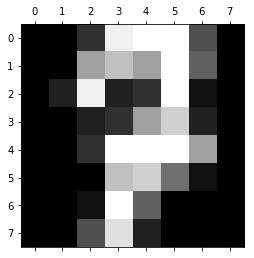

Label: 7
Prediction: 7

Image: 1


<Figure size 432x288 with 0 Axes>

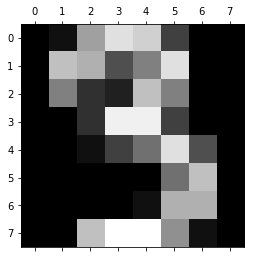

Label: 3
Prediction: 9

Image: 2


<Figure size 432x288 with 0 Axes>

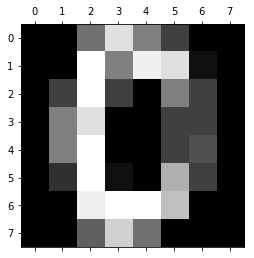

Label: 0
Prediction: 0

Image: 3


<Figure size 432x288 with 0 Axes>

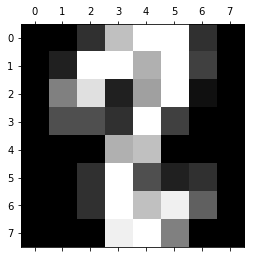

Label: 2
Prediction: 2

Image: 4


<Figure size 432x288 with 0 Axes>

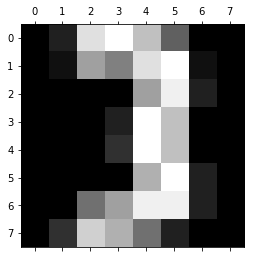

Label: 3
Prediction: 7

Image: 5


<Figure size 432x288 with 0 Axes>

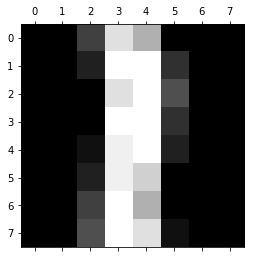

Label: 1
Prediction: 7

Image: 6


<Figure size 432x288 with 0 Axes>

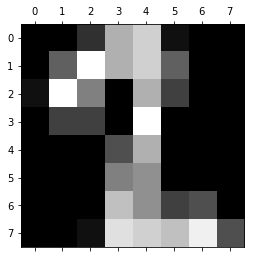

Label: 2
Prediction: 5

Image: 7


<Figure size 432x288 with 0 Axes>

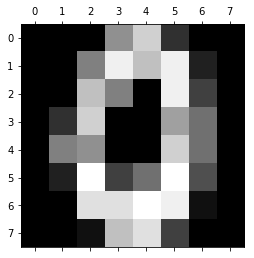

Label: 0
Prediction: 0

Image: 8


<Figure size 432x288 with 0 Axes>

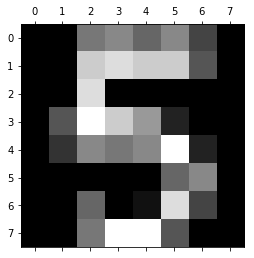

Label: 5
Prediction: 5

Image: 9


<Figure size 432x288 with 0 Axes>

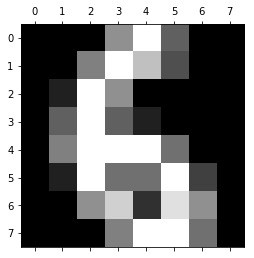

Label: 6
Prediction: 6



In [328]:
def plot_digit(feature_vector):
    dim = int(np.sqrt(len(feature_vector)))
    plt.gray()
    plt.matshow(feature_vector.reshape(dim,dim))
    plt.show()
    
def plot_test(index1,index2,clearn_,Xp,Xt,y):
    for index in range(index1,index2):
        print('Image:',index)
        plot_digit(Xp[index])
        ypred = clearn_.FPredict(Xt[index].reshape(1,-1))
        print('Label:', int(y[index]))
        print('Prediction:',int(ypred))
        print('')
        
plot_test(0,10,cnn,X_test,X_test_norm,y_test)

In [287]:

filt_info = CInfo([2,-1,2,2])
filt = CLayer('convolution',filt_info)

pool_info = CInfo([-1,2,2],2,2)
pool = CLayer('pool',pool_info)

conn_info = CInfo([-1,2])
conn = CLayer('connection',conn_info)

cnn = CNN([1,4,4],3,[filt,pool,conn],1,1)

cnn.layer[0].weight = np.arange(8).reshape(2,1,2,2)
cnn.layer[0].bias = np.arange(2).reshape(1,2)
cnn.layer[2].weight = np.arange(16).reshape(8,2).astype(float)
cnn.layer[2].bias = np.arange(2).reshape(1,2).astype(float)
cnn.layer[3].weight = np.arange(6).reshape(2,3).astype(float)
cnn.layer[3].bias = np.arange(3).reshape(1,3).astype(float)



X = np.arange(-16,16).reshape(2,1,4,4).astype(float)
X[1,0,1,1] = 10
y = np.arange(6).reshape(2,3).astype(float)
yhat = np.zeros(6).reshape(2,3).astype(float)
yhat[0][1] = 1
yhat[0][2] = -1
yhat[1][1] = 1
yhat[1][2] = -1

print('')
print('X\n',X)
print('')
print('y\n',y)
print('yhat\n',yhat)
cnn.FFeedForward(X)
print('')
print('y\n',y)
print('yhat\n',yhat)
print('y-yhat\n',y-yhat)
print('')
cnn.FBackPropagation(y,yhat)
#cnn.FPrint()


X
 [[[[-16. -15. -14. -13.]
   [-12. -11. -10.  -9.]
   [ -8.  -7.  -6.  -5.]
   [ -4.  -3.  -2.  -1.]]]


 [[[  0.   1.   2.   3.]
   [  4.  10.   6.   7.]
   [  8.   9.  10.  11.]
   [ 12.  13.  14.  15.]]]]

y
 [[0. 1. 2.]
 [3. 4. 5.]]
yhat
 [[ 0.  1. -1.]
 [ 0.  1. -1.]]

Filter Information:
  tag: convolution
  num_filt: 2
  num_ch: 1
  f_i: 2
  f_j: 2
  stride_i: 1
  stride_j: 1
  filt:
 [[[[0 1]
   [2 3]]]


 [[[4 5]
   [6 7]]]]
  bias:
 [[0 1]]
None
z [[[[ -72.  -66.  -60.]
   [ -48.  -42.  -36.]
   [ -24.  -18.  -12.]]

  [[-287. -265. -243.]
   [-199. -177. -155.]
   [-111.  -89.  -67.]]]


 [[[  39.   40.   36.]
   [  53.   54.   60.]
   [  72.   78.   84.]]

  [[ 100.  117.  109.]
   [ 178.  195.  197.]
   [ 241.  263.  285.]]]]
f [[[[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]]


 [[[ 39.  40.  36.]
   [ 53.  54.  60.]
   [ 72.  78.  84.]]

  [[100. 117. 109.]
   [178. 195. 197.]
   [241. 263. 285.

In [269]:
'''
import numpy as np
def InitializeFilter(dimensions):
    return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(dimensions))),size=dimensions)


def Convolution(images, filt, bias, activat, stride_i=1,stride_j=1):
    (num_filt, num_ch_f, f_i, f_j) = filt.shape
    (num_imag, num_ch, imag_i, imag_j) = images.shape
    
    if(num_ch_f != num_ch):
        print("Big mistake! The number of channels in the filter does not match the number of channels in the images!")

    out_i = int(np.ceil((imag_i - f_i)/stride_i) + 1)
    out_j = int(np.ceil((imag_j - f_j)/stride_j) + 1)
    z = np.zeros((num_imag, num_filt, out_i, out_j))
    i=0
    for image in images:
        for curr_f in range(num_filt):
            curr_y = curr_y_end = out_y = 0
            f_y_end = f_j + 1
            while(out_y < out_j):
                curr_x = curr_x_end = out_x = 0
                curr_y_end = curr_y + f_j
                if(curr_y_end > imag_j):
                    curr_y_end = imag_j
                    f_y_end = curr_y_end - curr_y
                f_x_end = f_i + 1
                while(out_x < out_i):
                    curr_x_end = curr_x + f_i
                    if(curr_x_end > imag_i):
                        curr_x_end = imag_i
                        f_x_end = curr_x_end - curr_x
                    z[i,curr_f,out_x,out_y] = np.sum(image[:,curr_x:curr_x_end,curr_y:curr_y_end]*filt[curr_f,:,0:f_x_end,0:f_y_end]) + bias[curr_f]
                    curr_x += stride_i
                    out_x += 1
                curr_y += stride_j
                out_y += 1
        i+=1
    return z,activat(z)

def FMaxPool(images,pool_i=2,pool_j=2,stride_i=2,stride_j=2):
    (num_imag, num_ch, imag_i, imag_j) = images.shape

    out_i = int(np.ceil((imag_i - pool_i)/stride_i)) + 1
    out_j = int(np.ceil((imag_j - pool_j)/stride_j)) + 1
    z = np.zeros((num_imag, num_ch, out_i, out_j))
    index = np.zeros((num_imag, num_ch, out_i, out_j))
    
    i=0
    for image in images:
        for curr_chan in range(num_ch):
            curr_y = out_y = 0
            while(out_y < out_j):
                curr_x = out_x = 0
                curr_y_end = curr_y + pool_j
                if(curr_y_end > imag_j):
                    current_y_end = imag_j
                while(out_x < out_i):
                    curr_x_end = curr_x + pool_i
                    if(curr_x_end > imag_i):
                        curr_x_end = imag_i
                    z[i,curr_chan,out_x,out_y] = np.max(image[curr_chan,curr_x:curr_x_end,curr_y:curr_y_end])
                    index[i,curr_chan,out_x,out_y] = np.argmax(image[curr_chan,curr_x:curr_x_end,curr_y:curr_y_end])
                    curr_x += stride_i
                    out_x +=1
                curr_y += stride_j
                out_y += 1
        i+=1
    return z,index

def FConnection(images,weights,bias,activation):
    z = images.dot(weights) + bias
    return z, activation(z)

def FbackConvolution(dprev,conv_in,filt,derivative,stride_i=1,stride_j=1):
    (num_filt, num_ch_f, f_i, f_j) = filt.shape
    (num_imag, num_ch, imag_i, imag_j) = conv_in.shape
    
    if(num_ch_f != num_ch):
        print("Big mistake! The number of channels in the filter does not match the number of channels in the input!")

    dout = np.zeros((num_ch,imag_i,imag_j))
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((num_filt,1))
    
    for conv in conv_in:
        dout_conv = np.zeros((num_ch,imag_i,imag_j))
        for curr_f in range(num_filt):
            curr_y = out_y = 0
            f_y_end = f_i
            while(curr_y + f_j < imag_j + 1):
                curr_x = out_x = 0
                curr_y_end = curr_y + f_j
                if(curr_y_end > imag_j):
                    curr_y_end = imag_j
                    f_y_end = curr_y_end - curr_y
                f_x_end = f_j
                while(curr_x + f_i < imag_i + 1): 
                    curr_x_end = curr_x + f_i
                    if(curr_x_end > imag_i):
                        curr_x_end = imag_i
                        f_x_end = curr_x_end - curr_i
                    dout_conv[:,curr_x:curr_x_end,curr_y:curr_y_end] += dprev[curr_f, out_x, out_y] * filt[curr_f,:,:f_x_end,:f_y_end]
                    dfilt[curr_f,:,:f_x_end,:f_y_end] += dprev[curr_f,out_x,out_y] * conv[:,curr_x:curr_x_end,curr_y:curr_y_end]

                    curr_x += stride_i
                    out_x +=1
                curr_y += stride_j
                out_y += 1
            dbias[curr_f] = np.sum(dprev[curr_f])
        dout += dout_conv*derivative(conv)

    return dout,dfilt,dbias

def FbackMaxPool(dpool, conv_in, p_i=2, p_j=2, stride_i=2, stride_j=2):
    (num_ch_p, dp_i, dp_j) = dpool.shape
    (num_imag, num_ch, imag_i, imag_j) = conv_in.shape
    
    if(num_ch_p != num_ch):
        print("Big mistake! The number of channels in dpool does not match the number of channels in the input!")

    dout = np.zeros((num_ch,imag_i,imag_j))
    
    for conv in conv_in:
        for curr_ch in range(num_ch):
            curr_y = curr_y_end = out_y = 0
            while(out_y < dp_j):
                curr_x = curr_x_end = out_x = 0
                curr_y_end = curr_y + p_j
                if(curr_y_end > imag_j):
                    curr_y_end = imag_j
                while(out_x < dp_i):
                    curr_x_end = curr_x + p_i
                    if(curr_x_end > imag_i):
                        curr_x_end = imag_i
                    (a,b) = np.unravel_index(np.nanargmax(conv[curr_ch,curr_x:curr_x_end,curr_y:curr_y_end]),conv[curr_ch,curr_x:curr_x_end,curr_y:curr_y_end].shape)
                    dout[curr_ch,curr_x+a,curr_y+b] += dpool[curr_ch,out_x,out_y]

                    curr_x += stride_i
                    out_x += 1
                curr_y += stride_j
                out_y += 1
    return dout

def FbackConnection(dprev,data_in,weight,activation,derivative):
    dW = activation(data_in).T.dot(dprev)
    db = np.sum(dprev,axis=0,keepdims=True)
    dout = dprev.dot(weight.T)*derivative(data_in)
    return dout, dW, db
    
#def Convolution(images, filt, bias, activation, stride_i=1,stride_j=1):



'''

'\nimport numpy as np\ndef InitializeFilter(dimensions):\n    return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(dimensions))),size=dimensions)\n\n\ndef Convolution(images, filt, bias, activat, stride_i=1,stride_j=1):\n    (num_filt, num_ch_f, f_i, f_j) = filt.shape\n    (num_imag, num_ch, imag_i, imag_j) = images.shape\n    \n    if(num_ch_f != num_ch):\n        print("Big mistake! The number of channels in the filter does not match the number of channels in the images!")\n\n    out_i = int(np.ceil((imag_i - f_i)/stride_i) + 1)\n    out_j = int(np.ceil((imag_j - f_j)/stride_j) + 1)\n    z = np.zeros((num_imag, num_filt, out_i, out_j))\n    i=0\n    for image in images:\n        for curr_f in range(num_filt):\n            curr_y = curr_y_end = out_y = 0\n            f_y_end = f_j + 1\n            while(out_y < out_j):\n                curr_x = curr_x_end = out_x = 0\n                curr_y_end = curr_y + f_j\n                if(curr_y_end > imag_j):\n                    curr_y_en